Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [218]:
from collections import namedtuple
from random import choice
from tqdm.auto import tqdm
import numpy as np
from heapq import heappush, heappop
import functools
import matplotlib.pyplot as plt
from time import time

In [219]:
np.random.seed(42)

In [220]:
PUZZLE_DIM = 4
RANDOMIZE_STEPS = 10_000
STEP_SIZE = 1000
TEMPERATURE = 10
MIN_PUZZLE_DIM = 8
MAX_PUZZLE_DIM = 9
TRIES_BASE = 10

action = namedtuple('Action', ['pos1', 'pos2'])

In [221]:
class State:
    def __init__(self, content: np.ndarray):
        self.content: np.ndarray = content
        self.hash: int = hash(content.tobytes())
        
    def __hash__(self):
        return self.hash

    def __eq__(self, other):
        return self.hash == other.hash
    
    def __lt__(self, other):
        return self.hash < other.hash

In [222]:
def available_actions(state: np.ndarray) -> list['Action']:
    puzzle_dim = state.shape[0]
    x, y = [int(i[0]) for i in np.where(state == 0)]
    actions = list()
    if x > 0:
        actions.append(action((x, y), (x - 1, y)))
    if x < puzzle_dim - 1:
        actions.append(action((x, y), (x + 1, y)))
    if y > 0:
        actions.append(action((x, y), (x, y - 1)))
    if y < puzzle_dim - 1:
        actions.append(action((x, y), (x, y + 1)))
    return actions

def counter(fn):

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def do_action(state: np.ndarray, action: 'Action') -> np.ndarray:
    new_state = state.copy()
    #print(action)
    new_state[action.pos1], new_state[action.pos2] = new_state[action.pos2], new_state[action.pos1]
    return new_state

## A* algorithm 

In [223]:
def get_pos(state_content: np.ndarray, n: int) -> tuple[int, int]:
    x, y = np.argwhere(state_content== n)[0]
    return x, y

def manhattan_distance(state: np.ndarray, goal: np.ndarray, n: int) -> int:
	x1, y1 = get_pos(state, n)
	x2, y2 = get_pos(goal, n)
	return abs(x1 - x2) + abs(y1 - y2)
 
def fixed_heuristic(state: np.ndarray, goal: np.ndarray, step: int = None, exp: float = None) -> int:
    puzzle_dim = state.shape[0]
    return sum([manhattan_distance(state, goal, n) for n in range(1, puzzle_dim**2)]) ** exp

def step_scheduling_heuristic(state: np.ndarray, goal: np.ndarray, step: int = TEMPERATURE * STEP_SIZE, exp: float = None) -> int:
    puzzle_dim = state.shape[0]
    return sum([manhattan_distance(state, goal, n) for n in range(1, puzzle_dim**2)]) ** (min(1 + (step // STEP_SIZE) / TEMPERATURE, 2))

def arctan_scheduling_heuristic(state: np.ndarray, goal: np.ndarray, step: int = TEMPERATURE * STEP_SIZE, exp: float = None) -> int:
	puzzle_dim = state.shape[0]
	return sum([manhattan_distance(state, goal, n) for n in range(1, puzzle_dim**2)]) ** (np.arctan(step / STEP_SIZE) + 1)

def quality(solution: list[int]) -> int:
    return -len(solution)

def astar(state: np.ndarray, goal: np.ndarray, heuristic, exp = None) -> tuple[bool, list['Action']]:
    
	path_len = lambda x: -quality(x)

	state, goal = map(State, [state, goal])
	open_set = []
	closed_set = set()
	parents = {}
	past_len = {state: 0}
 
	heappush(open_set, (0, state, []))
	closed_set.add(state)

	steps = 0
	while open_set:
		_, current, curr_path = heappop(open_set)

		if current == goal:
			return True, curr_path

		for action in available_actions(current.content):
			neighbor = State(do_action(current.content, action))

			if neighbor not in closed_set or past_len[current] + 1 < past_len[neighbor]:
				parents[neighbor] = current
				past_len[neighbor] = path_len(curr_path) + 1
				cost = past_len[neighbor] + heuristic(neighbor.content, goal.content, step=steps, exp=exp)
				heappush(open_set, (cost, neighbor, curr_path + [action]))
				closed_set.add(neighbor)

		steps += 1
    
	return False, []

In [224]:
strategies = ["fixed", "step scheduling", "arctan scheduling"]
functions = [fixed_heuristic, step_scheduling_heuristic, arctan_scheduling_heuristic]
heuristics = dict(zip(strategies, functions))

In [225]:
def is_solvable(state: np.ndarray) -> bool:
	state = state.flatten()
	inversions = 0
	for i in range(PUZZLE_DIM - 1):
		for j in range(i + 1, PUZZLE_DIM):
			if state[i] and state[j] and state[i] > state[j]:
				inversions += 1
	return inversions % 2 == 0

In [226]:
def init_state(goal: np.ndarray, puzzle_dim: int = PUZZLE_DIM, randomize_steps=RANDOMIZE_STEPS) -> np.ndarray:
    state = goal.copy()
    np.random.shuffle(state.flatten())
    for _ in range(randomize_steps):
        state = do_action(state, choice(available_actions(state)))
    return state.reshape(puzzle_dim, puzzle_dim)

def set_goal(puzzle_dim: int) -> np.ndarray:
    goal = np.array([n for n in range(1, puzzle_dim**2)] + [0])
    return goal.reshape((puzzle_dim, puzzle_dim)) 

In [227]:
def statistics(results_values):
    quality_sol, cost_sol, elapsed = tuple(zip(*(results_values)))
    avg_quality, avg_cost, avg_elapsed = map(lambda x: np.mean(np.array(x)), [quality_sol, cost_sol, elapsed])
    return avg_quality, avg_cost, avg_elapsed

## Solution

In [228]:
def solve_instance(puzzle_dim: int, heuristic, exp=None) -> np.ndarray:
    goal = set_goal(puzzle_dim)
    content = init_state(goal, puzzle_dim, randomize_steps=1400)
    do_action.calls = 0
    
    converged, path = astar(content, goal, heuristic, exp=exp)
    
    assert converged

    return quality(path), do_action.calls


def solve_size(puzzle_dim: int, heuristic, tries: int = TRIES_BASE, exp=None):
    
    qualities, costs = [], []
    for t in range(tries):
        print(f"Instance {t}")
        sol_quality, sol_cost = solve_instance(puzzle_dim, heuristic, exp=exp)
        qualities.append(sol_quality)
        costs.append(sol_cost)
    
    tot_quality, tot_cost = map(lambda x: np.array(x).mean(), [qualities, costs])
    
    return tot_quality, tot_cost, tot_quality / tot_cost


def solve(min_puz_dim, max_puz_dim, heuristics: dict, exp: dict = None, tries: dict = None):
    
    names = ["quality", "cost", "efficiency"]
    results = dict()
    for puzzle_dim in range(min_puz_dim, max_puz_dim+1):
        print(f"Solving for size {puzzle_dim}")
        sol_quality, sol_cost, sol_efficiency = solve_size(puzzle_dim, heuristics[puzzle_dim], tries[puzzle_dim], exp=exp[puzzle_dim])
        
        results[puzzle_dim] = dict(zip(names, [sol_quality, sol_cost, sol_efficiency]))
        
    return results

In [229]:
HEURISTICS_PER_SIZE = {
    2: fixed_heuristic,
    3: fixed_heuristic,
    4: fixed_heuristic,
    5: fixed_heuristic,
    6: fixed_heuristic,
    7: fixed_heuristic,
    8: fixed_heuristic,
    9: fixed_heuristic
}
EXP_PER_SIZE = {
    puzzle_dim: 1 if puzzle_dim <= 3 else 1.8 for puzzle_dim in range(MIN_PUZZLE_DIM, MAX_PUZZLE_DIM+1)
}
TRIES_PER_SIZE = {
    2: TRIES_BASE,
    3: TRIES_BASE,
    4: TRIES_BASE,
    5: TRIES_BASE // 2,
    6: TRIES_BASE // 4,
    7: TRIES_BASE // 8,
    8: TRIES_BASE // 8,
    9: TRIES_BASE // 8
}

In [230]:
def print_results(results):
    for (puzzle_dim, result) in results.items():
        print(f"Puzzle dimension: {puzzle_dim}")
        avg_quality, avg_cost, avg_efficiency = map(result.get, list(result.keys()))
        print(f"Quality: {avg_quality:.3f}")
        print(f"Cost: {avg_cost:.3f}")
        print(f"Efficiency: {avg_efficiency:.5f}")
        print()

In [231]:
def save_results(results: dict, index=0):
    import json
    OUTFILE =f"results89.json"
    file = open(OUTFILE, mode="w", encoding="utf-8")
    json.dump(results, file)

In [232]:
def plot_results(results):
    puz_dimensions, qualities, costs, efficiencies = [], [], [], []
    for (puzzle_dim, result) in results.items():
        avg_quality, avg_cost, avg_efficiency = map(result.get, list(result.keys()))
        
        puz_dimensions.append(puzzle_dim)
        qualities.append(avg_quality)
        costs.append(avg_cost)
        efficiencies.append(avg_efficiency)
    
    th = max(efficiencies)
    
    plt.figure("efficiency")
    
    plt.plot(puz_dimensions, efficiencies, label="Efficiency")
    plt.yscale("symlog", linthresh=-0.1*th)
    plt.title("Efficiency")
    plt.xlabel("Puzzle dimension")
    plt.ylabel("Efficiency")
    plt.grid()
    
    
    plt.show()

In [ ]:
results = solve(MIN_PUZZLE_DIM, MAX_PUZZLE_DIM, HEURISTICS_PER_SIZE, EXP_PER_SIZE, TRIES_PER_SIZE)

Solving for size 8
Instance 0


In [ ]:
results

NameError: name 'results' is not defined

In [ ]:
save_results(results)

In [ ]:
print_results(results)

Puzzle dimension: 2
Quality: -3.400
Cost: 7.600
Efficiency: -0.44737

Puzzle dimension: 3
Quality: -21.000
Cost: 3197.800
Efficiency: -0.00657

Puzzle dimension: 4
Quality: -120.400
Cost: 13452.000
Efficiency: -0.00895

Puzzle dimension: 5
Quality: -274.400
Cost: 253725.200
Efficiency: -0.00108

Puzzle dimension: 6
Quality: -387.000
Cost: 433519.500
Efficiency: -0.00089

Puzzle dimension: 7
Quality: -554.000
Cost: 548205.000
Efficiency: -0.00101



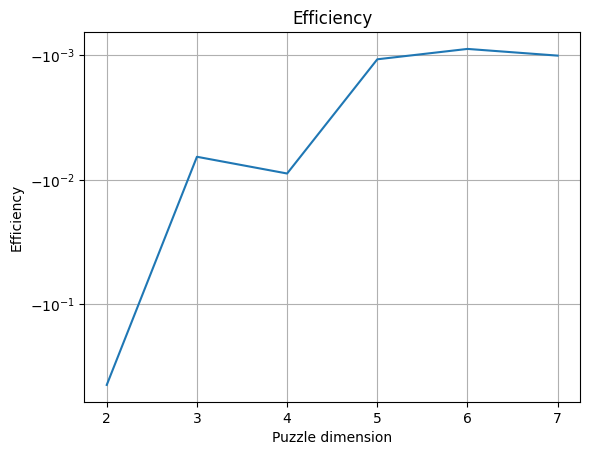

In [ ]:
plot_results(results)

## Experiments

In [ ]:
def solve(name, strategy, content, goal, exp=None):
	start = time()

	do_action.calls = 0
	success, path = astar(content, goal, strategy, exp=exp)
	elapsed = time() - start

	quality_sol, cost_sol = quality(path), do_action.calls
	print(f"{name}, {exp}: {success}, {quality_sol}, {cost_sol}, time: {elapsed:.2f} s")
	
	return ((name, exp), (quality_sol, cost_sol, elapsed))


def solve_instance(content, goal, results, heuristics=heuristics, exp_values=[2,3]):
	for (name, strategy) in heuristics.items():
		if name == "fixed":
			for exp in exp_values:
				algorithm, result = solve(name, strategy, content, goal, exp=exp)
				current = results.get(algorithm, [])
				current.append(result)
				results[algorithm] = current
		else:
			algorithm, result = solve(name, strategy, content, goal)
			current = results.get(algorithm, [])
			current.append(result)
			results[algorithm] = current

### Heuristic modification
Admissible heuristics are sometimes too slow at converging. The following part aims to find a non-admissible heuristic which can represent a good trade-off between optimality of the final solution and convergence time, which is related to the total cost of the problem (number of explored states).

In [ ]:
results = dict()	

TRIES = 15
for i in range(TRIES):
	goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
	content = init_state(goal)
	print(f"Instance {i}")
	print(content)
	solve_instance(content, goal, results)

for (algorithm, result) in results.items():
    avg_results = statistics(result)
    print(algorithm, avg_results)


# ('fixed', 2) (np.float64(133.08), np.float64(14753.52), np.float64(3.022707920074463))
# ('fixed', 3) (np.float64(159.32), np.float64(15408.64), np.float64(3.0712509107589723))
# ('step scheduling', None) (np.float64(106.88), np.float64(53037.26), np.float64(11.076385221481324))
# ('arctan scheduling', None) (np.float64(137.04), np.float64(26842.06), np.float64(5.3187418460845945))

### Test for randomizer step
This experiment focuses on understanding how could the number of initial randomize steps influence the final solution, in terms of quality and cost

In [ ]:
qualities, costs, elapseds = [], [], []

TRIES = 15
values = list(map(int, np.logspace(1, 7, num=TRIES).tolist()))
for (i, rand_steps) in enumerate(values):
	goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
	
	print(f"{i}: {rand_steps}")
 
	_TRIES = 10
	_qualities, _costs, _elapseds = map(np.zeros, [_TRIES] * 3)
	for _try in tqdm(range(_TRIES)):
		content = init_state(goal, randomize_steps=rand_steps)
		_, (sol_quality, sol_cost, sol_elapsed) = solve("fixed", fixed_heuristic, content, goal, exp=2)
		_qualities[_try] = sol_quality
		_costs[_try] = sol_cost
		_elapseds[_try] = sol_elapsed
	
	sol_quality = _qualities.mean()
	sol_cost = _costs.mean()
	sol_elapsed = _elapseds.mean()
	
	qualities.append(sol_quality)
	costs.append(sol_cost)
	elapseds.append(sol_elapsed)

In [ ]:
np.array(qualities), np.array(costs)

**Note**: the fist plot is scaled

In [ ]:
values = list(map(int, np.logspace(1, 7, num=15).tolist()))
mean = np.array(qualities).mean()
std = np.array(qualities).std()

plt.figure("quality", figsize=(14,8))
plt.semilogx(values, 10_000 * (np.array(qualities)) / std, color="blue", label="quality")
plt.semilogx(values, costs, color="red", label="cost")
plt.title("Quality vs Cost")

plt.legend()
plt.figure("elapsed", figsize=(14,8))
plt.semilogx(values, elapseds)
plt.title("Elapsed time (s)")
plt.figure("scatter", figsize=(14,8))
plt.scatter(costs, qualities)
plt.title("Quality vs. cost scatterplot")
plt.xlabel("Cost")
plt.ylabel("Quality")
for (i, (c, q)) in enumerate(zip(costs, qualities)):
    plt.annotate(f"{int(values[i]):2d}", (c,q))

plt.show()

In [ ]:
eff = ((np.array(qualities[2:]) / np.array(costs[2:]))).tolist()
plt.figure("efficiency", figsize=(14,8))
plt.semilogx(values[2:], eff, label=rand_steps)
plt.title("Efficiency vs. Random steps")
plt.xlabel("Random steps")
plt.ylabel("Efficiency")
plt.legend(title="Rand. steps")
plt.show()

#### Results
For n > 200, the scatter points are always in the same region.
Hence, it is expected the algorithm behave in the same way across different instances, given n greater than some constant N.

To have some safety margin N >= 1000 is chosen.

### Fine-grained fixed exponent
Fixed exponent is chosen, since it balances quality vs cost better than others.

**Note**: the second best could be arctan scheduling, with lower quality (25% estimated) but higher cost (3.5x).

The value of the exponent is tweaked around 2, in a small range

In [ ]:
results = dict()

fixed_heur = dict(zip([strategies[0]], [functions[0]]))
exp_values = np.linspace(1.5, 2.2, num=8).tolist()[::-1]      # 0.1 step, starting from fastest

rand_steps_values = [1000, 1400, 200_000]         # 1000 original value, others are maximums in the cost plot, not 1e6 due to high cost
for rand_steps in rand_steps_values:
    TRIES = 10
    for i in range(TRIES):
        goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
        content = init_state(goal, randomize_steps=rand_steps)
        print(f"Instance {i}")
        print(content)
        results[rand_steps] = dict()
        solve_instance(content, goal, results[rand_steps], heuristics=fixed_heur, exp_values=exp_values)

results


In [ ]:
avg_results = dict()
keys = ["quality", "cost", "elapsed"]

for (rand_steps, results_rand_steps) in results.items():
    avg_results[rand_steps] = dict()
    for ((_, exp), result) in results_rand_steps.items():
        avg_result = statistics(result)
        values = list(map(float, avg_result))
        avg_results[rand_steps][exp] = dict(zip(keys, values))

avg_results

In [ ]:
efficiencies = {rand_steps: [val["quality"]/val["cost"] for val in avg_results_steps.values()] for (rand_steps, avg_results_steps) in avg_results.items()}
efficiencies

In [ ]:
costs = {rand_steps: [val["cost"] for val in avg_results_steps.values()] for (rand_steps, avg_results_steps) in avg_results.items()}
costs

In [ ]:
plt.figure("eff vs. exp", figsize=(14,8))
colors = ["b", "r", "orange"]
for ((rand_steps, efficiencies_steps), (_, cost_steps), color) in zip(efficiencies.items(), costs.items(), colors):
    plt.plot(exp_values, efficiencies_steps, label=f"{rand_steps}", color=color)
plt.legend(title="Rand. steps")
plt.title("Efficiency vs Exponent")
plt.xlabel("Exponent")
plt.ylabel("Efficiency")

plt.show()

In [ ]:
plt.figure("cost vs. exp", figsize=(14,8))
colors = ["b", "r", "orange"]
#plt.plot(list(avg_results.keys()), [val["quality"] for val in avg_results.values()])
for ((rand_steps, cost_steps), color) in zip(costs.items(), colors):
    #print(rand_steps, efficiencies_steps, color)
    plt.plot(exp_values, cost_steps, label=f"{rand_steps}", color=color)
plt.legend(title="Rand. steps")
plt.title("Cost vs Exponent")
plt.xlabel("Exponent")
plt.ylabel("Cost")

plt.show()

In [ ]:
elaps = {rand_steps: [val["elapsed"] for val in avg_results_steps.values()] for (rand_steps, avg_results_steps) in avg_results.items()} 

In [ ]:
plt.figure("eff vs. exp", figsize=(14,8))
colors = ["b", "r", "orange"]
#plt.plot(list(avg_results.keys()), [val["quality"] for val in avg_results.values()])
for ((rand_steps, elapsed_steps), color) in zip(elaps.items(), colors):
    plt.plot(exp_values, elapsed_steps, label=f"{rand_steps}", color=color)
plt.legend(title="Rand. steps")
plt.title("Elapsed time vs Exponent")
plt.xlabel("Exponent")
plt.ylabel("Elapsed time")

plt.show()

#### Results
To avoid higher costs in larger problems, a low cost is preferred: by putting a threshold on 2 seconds, following setups are considered:
- rand steps = 1400, 1.7 <= exp <= 1.9
- rand_steps = 200_000, all possible exponents.

Efficiency is then considered:
- rand_steps = 1400, in general better on the given interval, faster initialization
- rand_steps = 200_000, slightly more efficient in 1.8, but in general worse -> The good efficiency value could be a sort of glitch or coincidence, caused by the limited number of tries

In conclusion:
- rand_steps = 1400, due to better general behavior
- exp = 1.8, due to lower cost in the region
  
could be a good solution. 